## Importar librerias

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.offline as pyo # para exportar en html
import plotly.express as px
import json
from urllib.request import urlopen


## Importar json con las ubicaciones por departamento

In [2]:
with urlopen(
        'https://raw.githubusercontent.com/macortesgu/MGN_2021_geojson/main/MGN2021_DPTO_web.geo.json') as response:
    departamentos = json.load(response)

with urlopen(
        'https://raw.githubusercontent.com/macortesgu/MGN_2021_geojson/main/MGN2021_MPIO_web.geo.json') as response:
    municipios = json.load(response)


## Cargar base de datos y calcular valores de cumplimiento para los mapas


In [3]:
PATH = "F:\CREG\Regulación - Energía - EE-D-Calidad - EE-D-Calidad\VERIFICACIONES_CALIDAD_AUX\Ejemplo cálculo indicadores\\V2\\"

df_DIU = pd.read_excel(PATH+'2.Ejemplo_cálculo_indicadores_v2.xlsx', sheet_name='DIU_x_usuario',
                       header=0, usecols="C:V", skiprows=37, nrows=19557)
df_FIU = pd.read_excel(PATH+'2.Ejemplo_cálculo_indicadores_v2.xlsx', sheet_name='FIU_x_usuario',
                       header=0, usecols="C:V", skiprows=37, nrows=19557)

In [4]:
pt_df_DIU = pd.DataFrame(pd.pivot_table(df_DIU,
                                        values=['Cumple calidad garantizada'],
                                        #columns=['Cumple calidad garantizada'],
                                        index=['DEPARTAMENTO', 'm'],
                                        aggfunc=['sum', 'count'], fill_value=0).to_records())
dicc = {"('sum', 'Cumple calidad garantizada')": 'Cumple_DIUG',
        "('count', 'Cumple calidad garantizada')": 'Total_usuarios'}
for key, value in dicc.items():
    try:
        pt_df_DIU.rename(columns={key: value}, inplace=True)
    except KeyError:
        continue

In [5]:
pt_df_FIU = pd.DataFrame(pd.pivot_table(df_FIU,
                                        values=['Cumple calidad garantizada'],
                                        #columns=['Cumple calidad garantizada'],
                                        index=['DEPARTAMENTO', 'm'],
                                        aggfunc=['sum', 'count'], fill_value=0).to_records())
dicc = {"('sum', 'Cumple calidad garantizada')": 'Cumple_FIUG',
        "('count', 'Cumple calidad garantizada')": 'Total_usuarios'}
for key, value in dicc.items():
    try:
        pt_df_FIU.rename(columns={key: value}, inplace=True)
    except KeyError:
        continue

In [6]:
pt_df_DIU['Cumplimiento_DIUG'] = 100*pt_df_DIU.Cumple_DIUG/pt_df_DIU.Total_usuarios
pt_df_FIU['Cumplimiento_FIUG'] = 100*pt_df_FIU.Cumple_FIUG/pt_df_FIU.Total_usuarios

## Crear Mapas

### Se hacen dos tipos de mapa, uno estático para poner en los informes, y uno dinámico que se exporta en html

In [19]:
# Tablas de geopandas para el mes de diciembre. De manera similar se pueden crear tablas para graficar los demás meses del año cambiando el mes filtrado.
gdf_data = (
    gpd.GeoDataFrame.from_features(departamentos)
    .merge(pt_df_DIU.loc[pt_df_DIU.m == 12], left_on="DPTO_CNMBR", right_on="DEPARTAMENTO")
    .assign(lat=lambda d: d.geometry.centroid.y, lon=lambda d: d.geometry.centroid.x)
    .set_index("DPTO_CNMBR", drop=False)
)
gdf_data_frecuencia = (
    gpd.GeoDataFrame.from_features(departamentos)
    .merge(pt_df_FIU.loc[pt_df_FIU.m == 12], left_on="DPTO_CNMBR", right_on="DEPARTAMENTO")
    .assign(lat=lambda d: d.geometry.centroid.y, lon=lambda d: d.geometry.centroid.x)
    .set_index("DPTO_CNMBR", drop=False)
)
# Para el croquis de los departamentos
gdf_deptos = (
    gpd.GeoDataFrame.from_features(departamentos)
    .assign(lat=lambda d: d.geometry.centroid.y, lon=lambda d: d.geometry.centroid.x)
    .set_index("DPTO_CNMBR", drop=False)
)

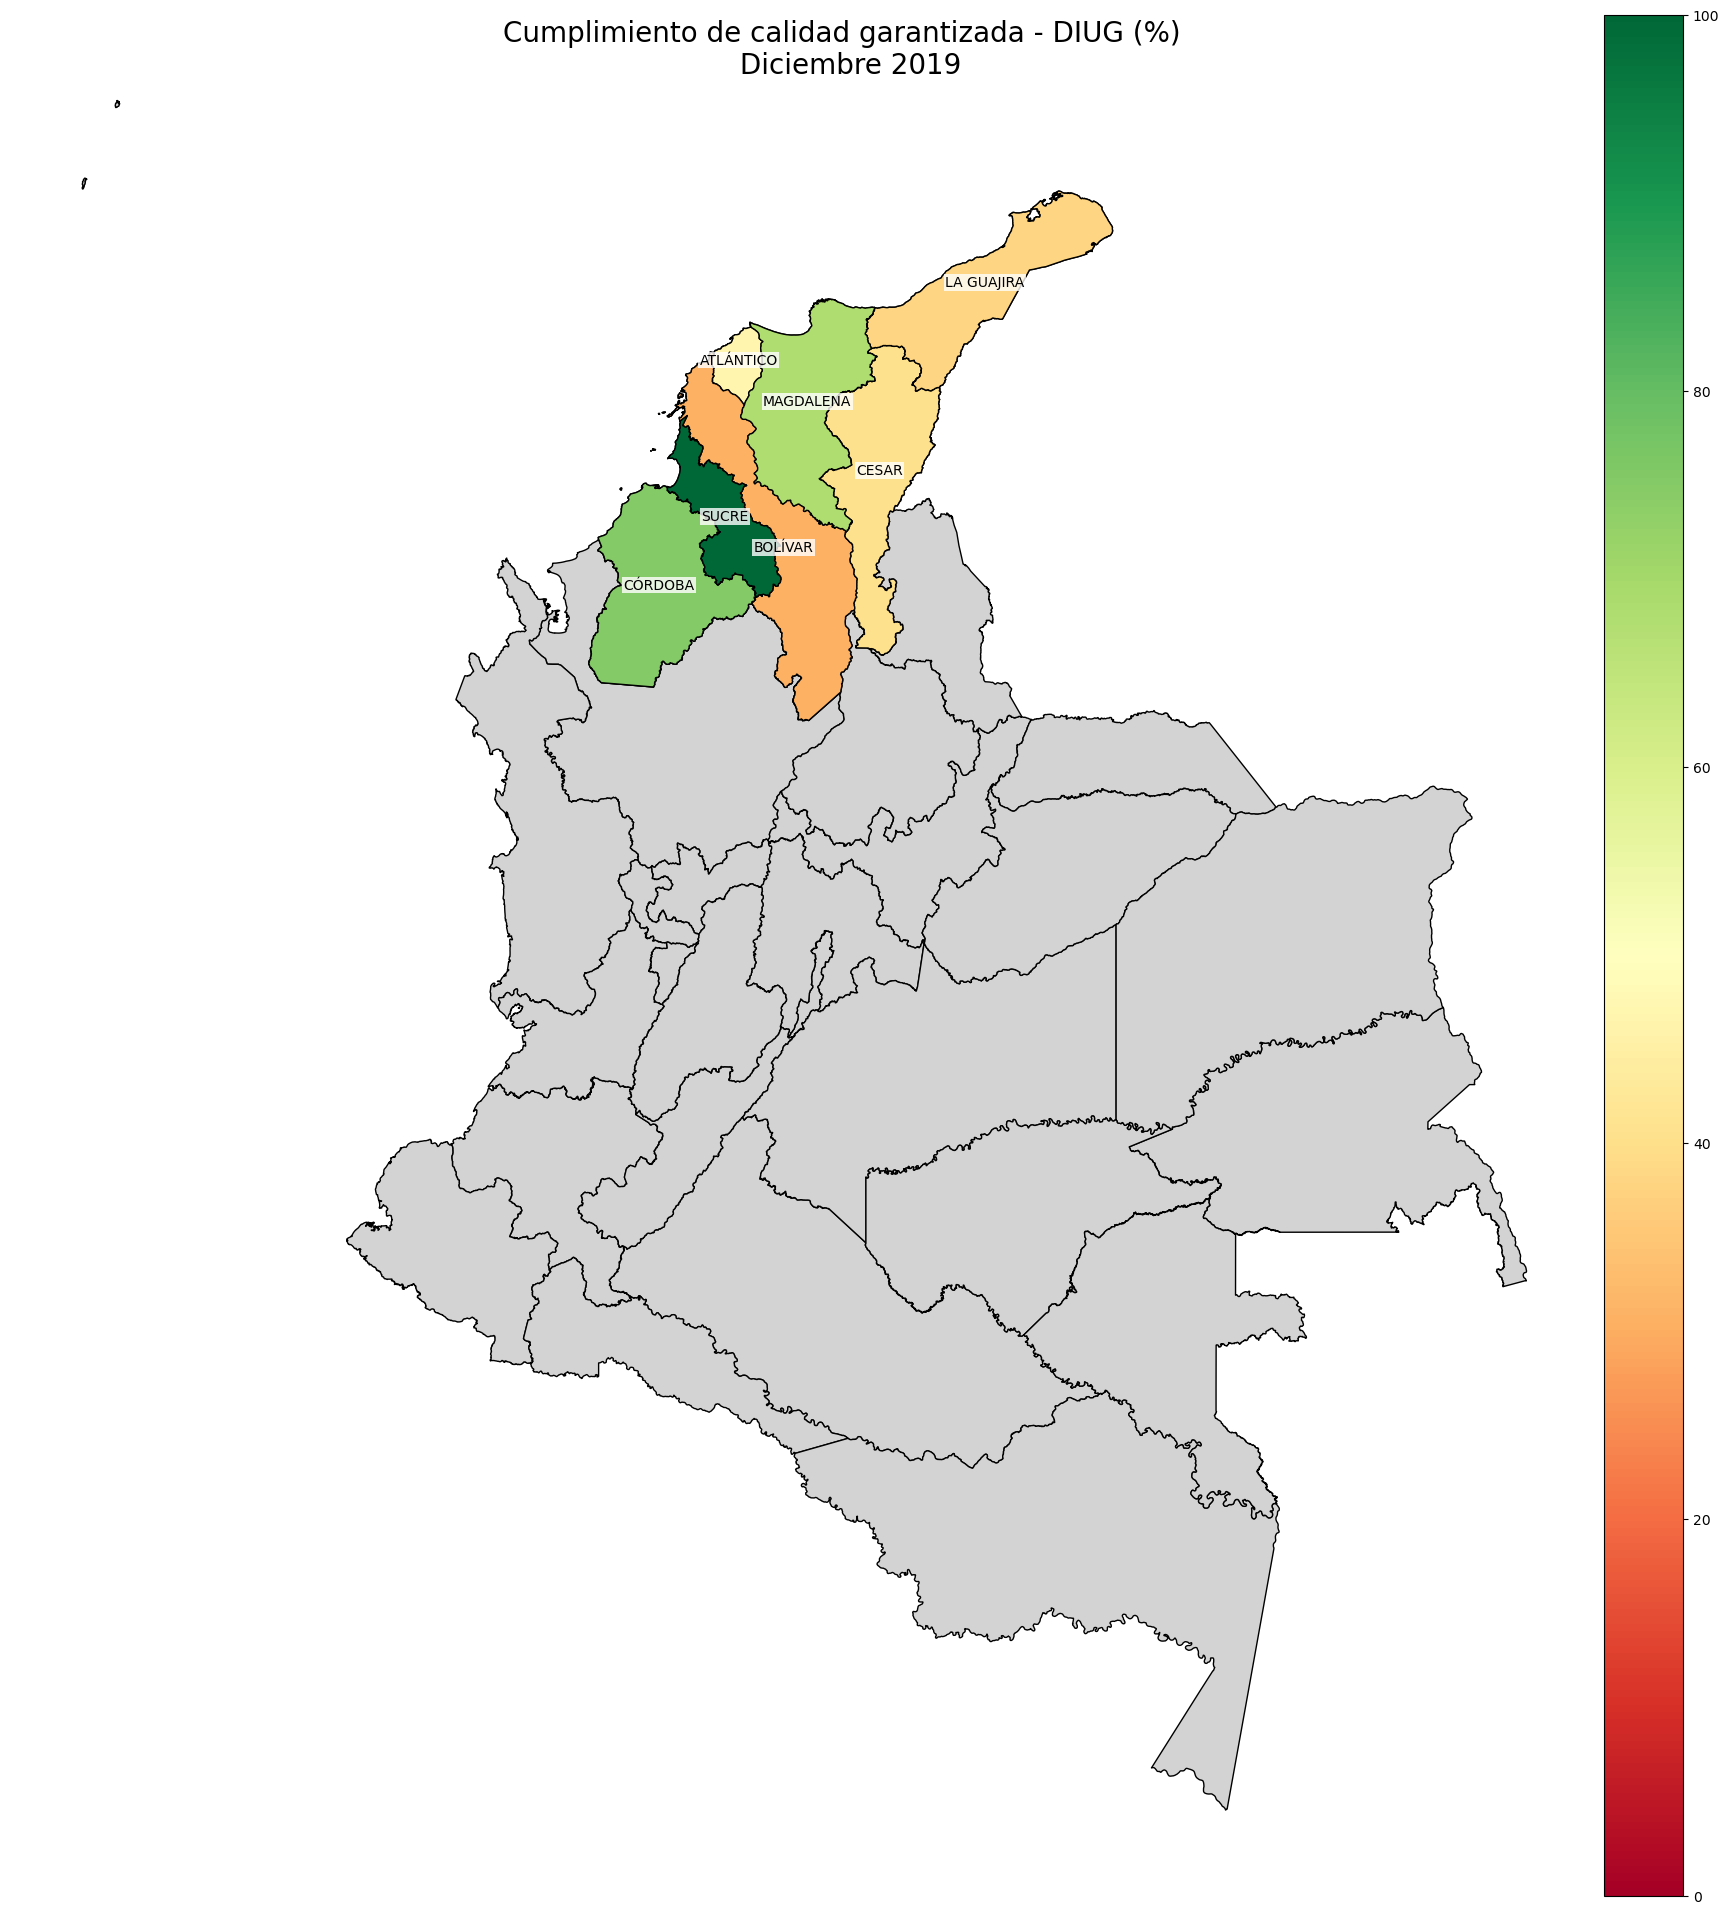

In [9]:
# Duración
# Crear figura y ejes.
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_axis_off()

# Graficar el croquis de departamentos
gdf_deptos.plot(ax=ax, color='lightgrey', edgecolor='black', cax=cax)

# Graficar los departamentos con información de indicadores
gdf_data.plot(column='Cumplimiento_DIUG', ax=ax, vmin=0, vmax=100, legend=True, cmap='RdYlGn', edgecolor='black', cax=cax)

# Poner etiquetas con los nombres de los departamentos que tienen indicador calculado
gdf_data.apply(lambda x: ax.annotate(text=x['DEPARTAMENTO'], xy=x.geometry.centroid.coords[0], ha='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 1, 'edgecolor':'none'}), axis=1)

fig.suptitle('Cumplimiento de calidad garantizada - DIUG (%) \n Diciembre 2019', fontsize=20, y=0.95)
fig.tight_layout()
fig.savefig(PATH+'Cumplimiento_DIUG_2019_12.pdf')

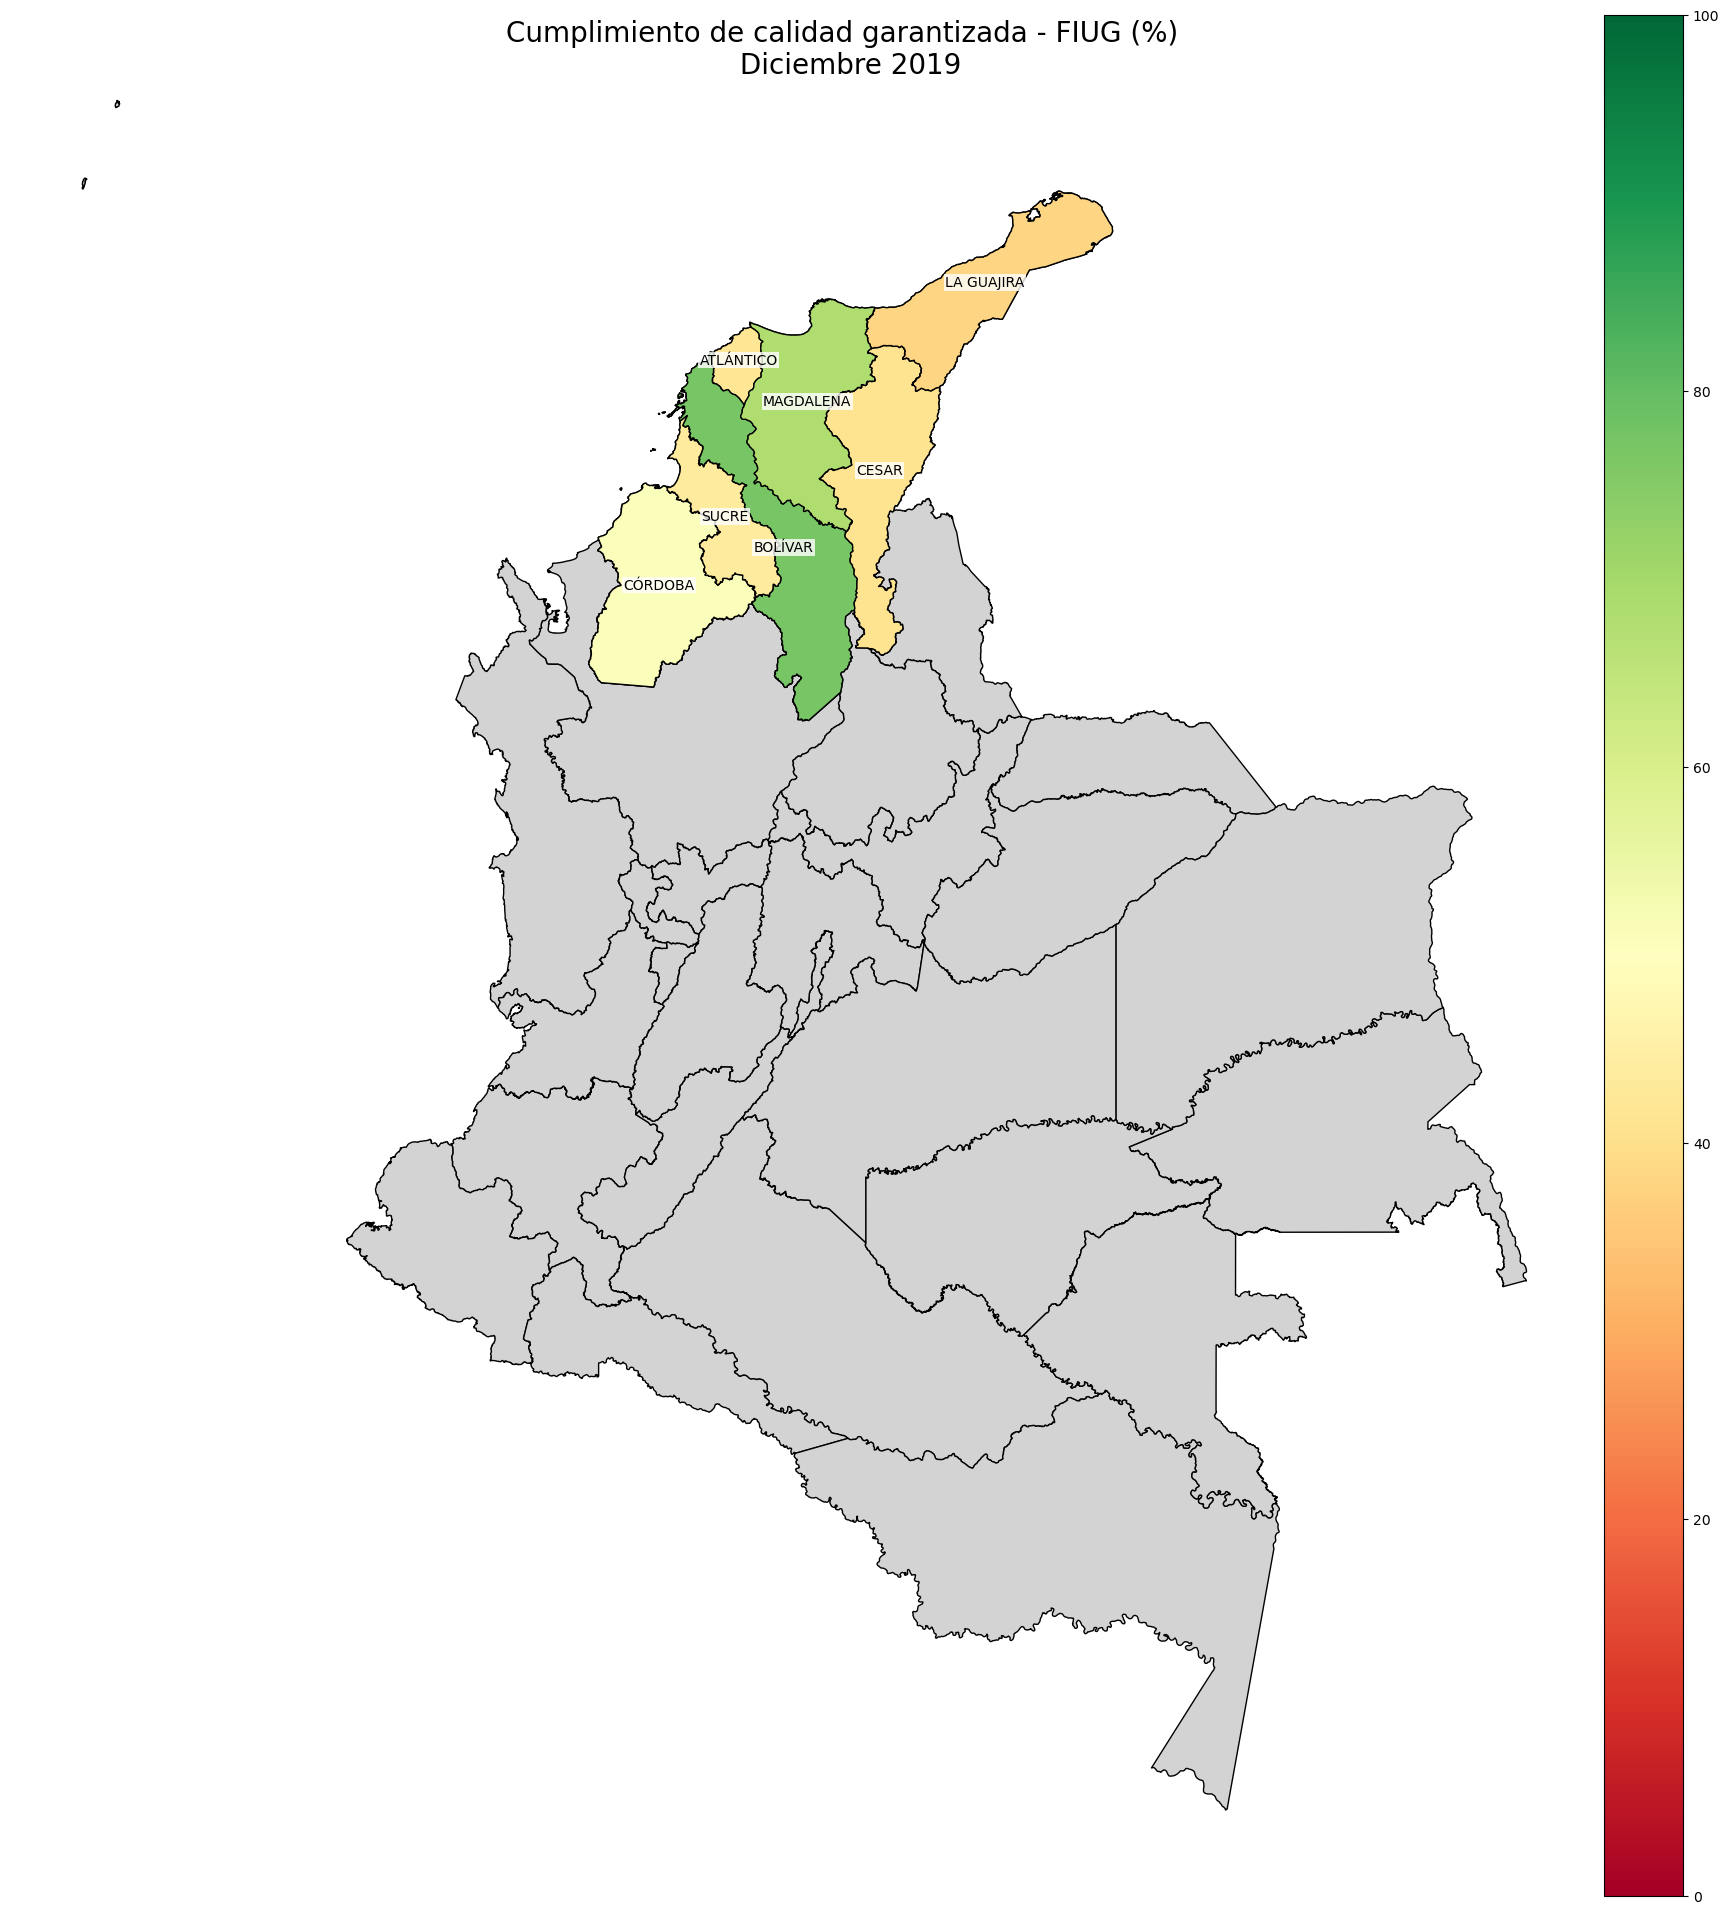

In [29]:
# Frecuencia
# Crear figura y ejes
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 20))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
ax2.set_axis_off()

# Graficar el croquis de departamentos
gdf_deptos.plot(ax=ax2, color='lightgrey', edgecolor='black', cax=cax)

# Graficar los departamentos con información de indicadores
gdf_data_frecuencia.plot(column='Cumplimiento_FIUG', ax=ax2, vmin=0, vmax=100, legend=True, cmap='RdYlGn', edgecolor='black', cax=cax2)

# Poner etiquetas con los nombres de los departamentos que tienen indicador calculado
gdf_data_frecuencia.apply(lambda x: ax2.annotate(text=x['DEPARTAMENTO'], xy=x.geometry.centroid.coords[0], ha='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 1, 'edgecolor':'none'}), axis=1)

fig2.suptitle('Cumplimiento de calidad garantizada - FIUG (%) \n Diciembre 2019', fontsize=20, y=0.95)
fig2.tight_layout()
fig2.savefig(PATH+'Cumplimiento_FIUG_2019_12.pdf')

### Mapas para exportar en html

#### Departamento

In [ ]:
for loc in departamentos['features']:
    loc['id'] = loc['properties']['DPTO_CNMBR']

In [22]:
fig_ply = px.choropleth_mapbox(pt_df_DIU, geojson=departamentos, locations='DEPARTAMENTO',
                               color='Cumplimiento_DIUG', animation_frame='m',
                               color_continuous_scale="rdylgn",
                               range_color=(0, 100),
                               mapbox_style="carto-positron",
                               zoom=3.4, center = {"lat": 4.570868, "lon": -74.2973328},
                               opacity=0.75,
                               labels={'Cumplimiento_DIUG':'Cumplimiento DIUG (%)'}
                               )
fig_ply.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
pyo.plot(fig_ply, filename = PATH+'Mapa_cumplimiento_DIUG_web.html')
# fig_ply.show()

'F:\\CREG\\Regulación - Energía - EE-D-Calidad - EE-D-Calidad\\VERIFICACIONES_CALIDAD_AUX\\Ejemplo cálculo indicadores\\V2\\Mapa_cumplimiento_DIUG_web.html'

In [24]:
fig_ply_fiug = px.choropleth_mapbox(pt_df_FIU, geojson=departamentos, locations='DEPARTAMENTO',
                               color='Cumplimiento_FIUG', animation_frame='m',
                               color_continuous_scale="rdylgn",
                               range_color=(0, 100),
                               mapbox_style="carto-positron",
                               zoom=3.4, center = {"lat": 4.570868, "lon": -74.2973328},
                               opacity=0.75,
                               labels={'Cumplimiento_FIUG':'Cumplimiento FIUG (%)'}
                               )
fig_ply_fiug.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
pyo.plot(fig_ply_fiug, filename = PATH+'Mapa_cumplimiento_FIUG_web.html')
# fig_ply.show()

'F:\\CREG\\Regulación - Energía - EE-D-Calidad - EE-D-Calidad\\VERIFICACIONES_CALIDAD_AUX\\Ejemplo cálculo indicadores\\V2\\Mapa_cumplimiento_FIUG_web.html'

#### Municipio

In [16]:
pt_df_DIU_mpio = pd.DataFrame(pd.pivot_table(df_DIU,
                                        values=['Cumple calidad garantizada'],
                                        #columns=['Cumple calidad garantizada'],
                                        index=['DEPARTAMENTO', 'MUNICIPIO', 'm'],
                                        aggfunc=['sum', 'count'], fill_value=0).to_records())
dicc = {"('sum', 'Cumple calidad garantizada')": 'Cumple_DIUG',
        "('count', 'Cumple calidad garantizada')": 'Total_usuarios'}
for key, value in dicc.items():
    try:
        pt_df_DIU_mpio.rename(columns={key: value}, inplace=True)
    except KeyError:
        continue

pt_df_FIU_mpio = pd.DataFrame(pd.pivot_table(df_FIU,
                                             values=['Cumple calidad garantizada'],
                                             #columns=['Cumple calidad garantizada'],
                                             index=['DEPARTAMENTO', 'MUNICIPIO', 'm'],
                                             aggfunc=['sum', 'count'], fill_value=0).to_records())
dicc = {"('sum', 'Cumple calidad garantizada')": 'Cumple_FIUG',
        "('count', 'Cumple calidad garantizada')": 'Total_usuarios'}
for key, value in dicc.items():
    try:
        pt_df_FIU_mpio.rename(columns={key: value}, inplace=True)
    except KeyError:
        continue

pt_df_DIU_mpio['DEPTO_MPIO'] = pt_df_DIU_mpio.DEPARTAMENTO + '_' + pt_df_DIU_mpio.MUNICIPIO
pt_df_DIU_mpio['Cumplimiento_DIUG'] = 100*pt_df_DIU_mpio.Cumple_DIUG/pt_df_DIU_mpio.Total_usuarios
pt_df_FIU_mpio['DEPTO_MPIO'] = pt_df_FIU_mpio.DEPARTAMENTO + '_' + pt_df_FIU_mpio.MUNICIPIO
pt_df_FIU_mpio['Cumplimiento_FIUG'] = 100*pt_df_FIU_mpio.Cumple_FIUG/pt_df_FIU_mpio.Total_usuarios

In [17]:
for loc in municipios['features']:
    loc['id'] = loc['properties']['DEPTO_MPIO']

In [18]:
fig_mpio = px.choropleth_mapbox(pt_df_DIU_mpio, geojson=municipios, locations='DEPTO_MPIO',
                          color='Cumplimiento_DIUG', animation_frame='m',
                          color_continuous_scale="rdylgn",
                          range_color=(0, 100),
                          mapbox_style="carto-positron",
                          zoom=3.4, center = {"lat": 4.570868, "lon": -74.2973328},
                          opacity=0.75,
                          labels={'Cumplimiento_DIUG':'Cumplimiento DIUG (%)'}
                          )
fig_mpio.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
pyo.plot(fig_mpio, filename = PATH+'Mapa_cumplimiento_DIUG_web_municipio.html')
# fig.show()

'F:\\CREG\\Regulación - Energía - EE-D-Calidad - EE-D-Calidad\\VERIFICACIONES_CALIDAD_AUX\\Ejemplo cálculo indicadores\\V2\\Mapa_cumplimiento_DIUG_web_municipio.html'

In [27]:
fig_mpio_fiug = px.choropleth_mapbox(pt_df_FIU_mpio, geojson=municipios, locations='DEPTO_MPIO',
                                color='Cumplimiento_FIUG', animation_frame='m',
                                color_continuous_scale="rdylgn",
                                range_color=(0, 100),
                                mapbox_style="carto-positron",
                                zoom=3.4, center = {"lat": 4.570868, "lon": -74.2973328},
                                opacity=0.75,
                                labels={'Cumplimiento_FIUG':'Cumplimiento FIUG (%)'}
                                )
fig_mpio_fiug.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
pyo.plot(fig_mpio_fiug, filename = PATH+'Mapa_cumplimiento_FIUG_web_municipio.html')

'F:\\CREG\\Regulación - Energía - EE-D-Calidad - EE-D-Calidad\\VERIFICACIONES_CALIDAD_AUX\\Ejemplo cálculo indicadores\\V2\\Mapa_cumplimiento_FIUG_web_municipio.html'